**Settings**

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import keras
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

2023-05-18 18:46:02.533187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 18:46:02.646658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 18:46:02.646673: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-18 18:46:02.671490: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-18 18:46:03.245632: W tensorflow/stream_executor/platform/de

In [2]:
#requisits and ignore warnings
import warnings
warnings.simplefilter('ignore')

import fnmatch
import collections
import keras
import librosa
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import models, layers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot, cm
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

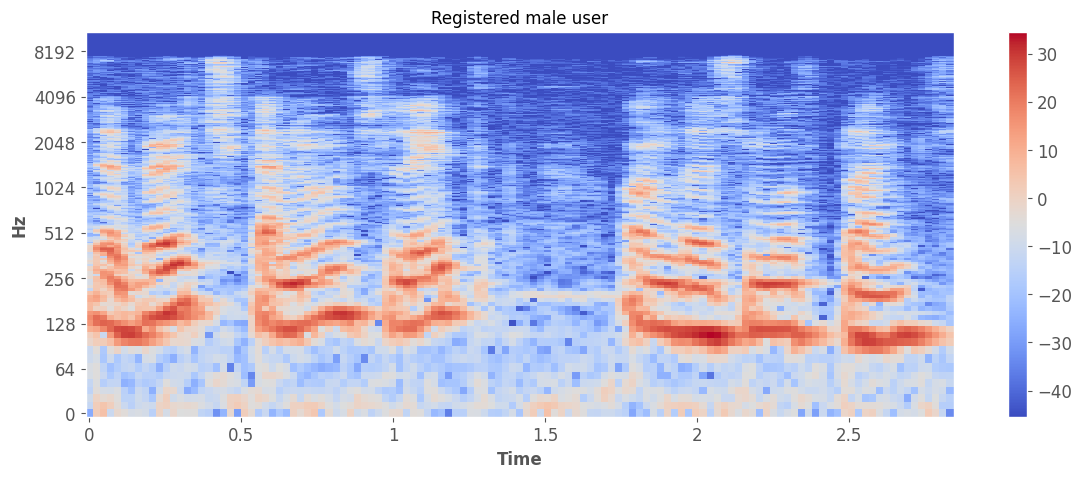

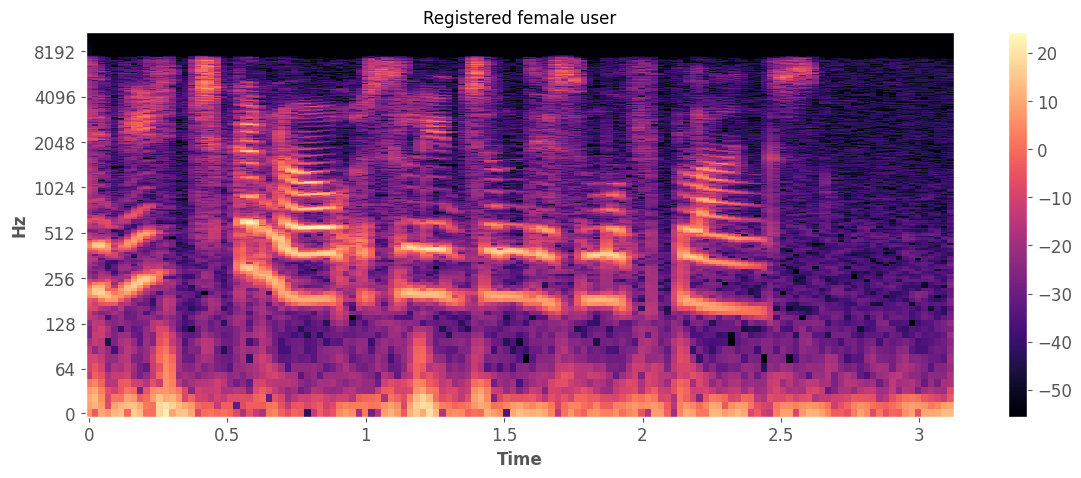

In [3]:
x,sr = librosa.load('/home/silvia/Escritorio/tfm/Server_auth/audios/audios/56_speakers_audio_data/Speaker0062/Speaker0062_000.wav')
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title('Registered male user')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
x,sr = librosa.load('/home/silvia/Escritorio/tfm/Server_auth/audios/audios/56_speakers_audio_data/Speaker0061/Speaker0061_000.wav')
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title('Registered female user')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

2.8448526077097505


(-0.011609977324263039, 2.844444444444444)

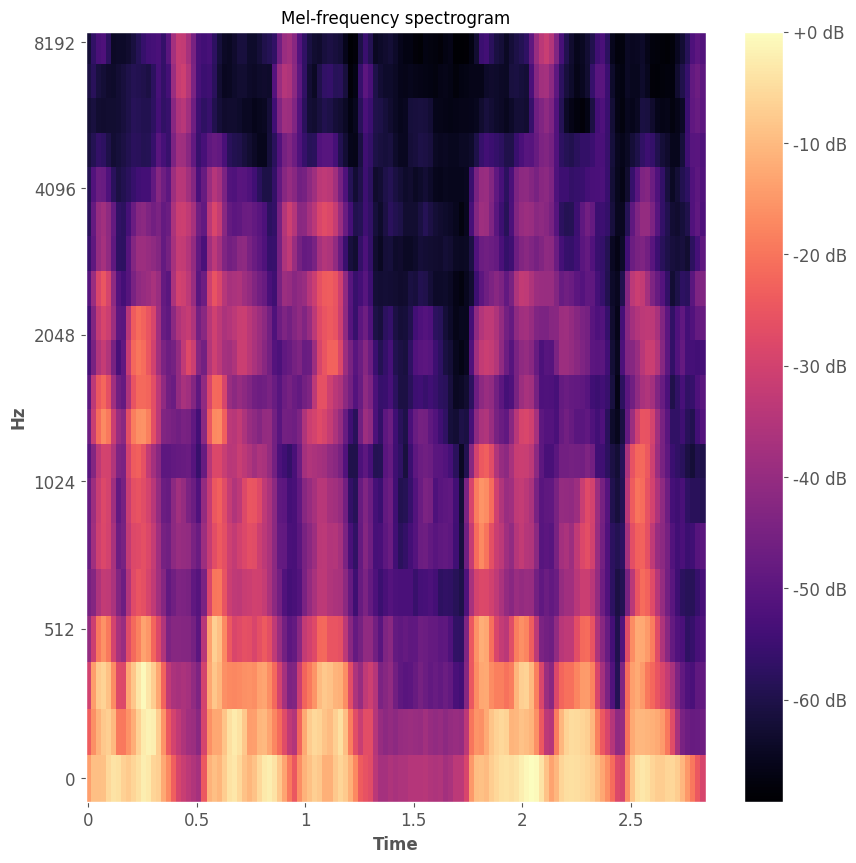

In [16]:
y,sr = librosa.load('/home/silvia/Escritorio/tfm/Server_auth/audios/audios/56_speakers_audio_data/Speaker0062/Speaker0062_000.wav')
dur_time = librosa.get_duration(y=y,sr=sr)
print(dur_time)
time_sec = round(dur_time)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.xlim()

In [5]:
time_series_sec=np.linspace(0, time_sec, len(S_dB[0]))

The output of this section is the CSV files with the data to be handle by the model

```
trainData     : audio/train 
testData      : audio/test
```


In [2]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "train.csv"
TEST_CSV_FILE = "test.csv"
final_test="final_test.csv"

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import librosa
import csv
import os
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')

def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in tqdm(os.listdir(soundFilesFolder)):
        number = f'{soundFilesFolder}/{filename}'
        y, sr = librosa.load(number, mono=True, duration=30)
        # remove leading and trailing silence
        y, index = librosa.effects.trim(y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")
    

In [76]:
extractWavFeatures("audios/audios/train", TRAIN_CSV_FILE)
extractWavFeatures("audios/audios/test", TEST_CSV_FILE)
print("CSV files are created")

The features of the files in the folder audios/audios/train will be saved to train.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|███████████████████████████████████████| 3255/3255 [16:15<00:00,  3.34it/s]


End of extractWavFeatures
The features of the files in the folder audios/audios/test will be saved to test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|█████████████████████████████████████████| 836/836 [04:06<00:00,  3.40it/s]

End of extractWavFeatures
CSV files are created


In [65]:
import pandas as pd
import csv
from sklearn import preprocessing

def preProcessData(csvFileName):
    print(csvFileName+ " will be preprocessed")
    data = pd.read_csv(csvFileName)
    filenameArray = data['filename'] 
    speakerArray = []
    #print(filenameArray)
    for i in range(len(filenameArray)):
        speaker = int(filenameArray[i].split("_")[0].split("r")[1])
        #print(speaker)
        #print(speaker)
        speakerArray.append(speaker)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    data.shape

    print("Preprocessing is finished")
    print(data.head())
    return data



In [66]:
trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)

train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.045045        1884.551145         1884.392273  3490.138591   
1  0.041535        1890.483000         1823.300517  3447.555889   
2  0.040087        1916.180851         2040.020857  3828.373339   
3  0.041385        1927.393116         1901.614136  3561.867222   
4  0.044173        1808.059218         1868.406685  3434.212309   

   zero_crossing_rate       mfcc1      mfcc2     mfcc3      mfcc4      mfcc5  \
0            0.100688 -353.494141  93.906677  7.912910  34.680305  10.011774   
1            0.103872 -350.396698  98.753326  8.569983  33.973907   9.793419   
2            0.096558 -390.998199  84.462677  8.566958  33.107719  10.663301   
3            0.102573 -358.863861  96.531067  9.463179  34.748562  10.652501   
4            0.098015 -372.632019  92.611893  9.020912  29.243792  11.028229   

   ...    mfcc12    mfcc13    mfcc14    mfcc15    mfcc16   

In [67]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)


X_test = np.array(testData.iloc[:, :-1], dtype = float)
y_test = testData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)


Y from training data: (5,)
Y from validation data: (3,)
Y from test data: (2,)


In [68]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)


X from training data (5, 25)
X from validation data (3, 25)
X from test data (2, 25)


In [72]:
import os
import fnmatch
import collections
weight={}
path='/home/silvia/Escritorio/tfm/Server_auth/audios/audios/56_speakers_audio_data'
for speaker in os.listdir(path):
    if speaker.find(".sh")==-1:
        dir_path=path+'/'+speaker
        speaker = int(speaker.split("_")[0].split("r")[1])
        count = int(len(fnmatch.filter(os.listdir(dir_path), '*.*'))*0.8)-1
        weight.update({speaker: count})
max_value=sum(weight.values())
print("Sum of values: "+str(max_value))
weight = {key: value for key, value in sorted(weight.items())}
weight = {k: 1-(v/max_value) for k, v in weight.items()}
print(weight.keys())
print(set(range(57)) - set(y_train))

Sum of values: 3200
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56}


In [70]:
#Creating a Model
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
layer1=layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],))
layer2=layers.Dropout(0.5)
layer3=layers.Dense(128, activation='relu')
layer4=layers.Dropout(0.5)
layer5=layers.Dense(64, activation='relu')
layer6=layers.Dropout(0.5)
layer7=layers.Dense(100, activation='softmax')

model.add(layer1)
model.add(layer2)
model.add(layer3)
model.add(layer4)
model.add(layer5)
model.add(layer6)
model.add(layer7)

# Learning Process of a model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
print(X_train)
#Train with early stopping to avoid overfitting
y_train=np.array(y_train, dtype=int)
y_val=np.array(y_val, dtype=int)
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),epochs=100,batch_size=128,class_weight=weight, callbacks=[es])

#Transfer learning
layer1.trainable=False
layer3.trainable=False

[[-1.26766479  0.77384879  1.80244983  1.90646285 -1.79039077 -1.66849059
  -1.74726311  0.35863489 -0.8482527   1.09123589  0.46727735  1.90800207
   0.66813312  0.34841136 -0.24082515  1.10084924  1.63619656 -1.31938908
  -0.04440636  1.02744452  0.17514218  0.96451596  1.95328403 -1.72283383
   1.76982872]
 [-0.49419437  0.04438614 -0.82110186 -0.73248663  1.16546408  1.00796882
   1.15677386  0.36187773 -0.54313816 -1.42992213  0.18126171 -0.22459683
   0.27528324  0.72714947  0.67496378 -0.2207895  -0.64519675  0.30641591
   0.09929358 -0.62189494 -0.03273241  0.55515552 -0.46652976  1.34317764
  -0.29752154]
 [-0.57458042  1.09212165  0.12693942  0.05965625  0.6405532   0.44981167
   0.7051832   1.31968087 -0.27026634  1.05993349 -0.40197641 -0.410342
   0.71357942  0.48547005  1.19740042  0.79712004 -0.48244401 -0.60934984
   1.22096526 -1.58300634 -1.59092084 -0.13473135 -0.24131837 -0.1327502
  -1.09579809]
 [ 0.95705601 -1.78636031 -1.02674408 -0.79623105  0.10568533 -0.59307

InvalidArgumentError: Graph execution error:

indices[0] = 55 is not in [0, 55)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_42061]

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               6656      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 100)              

### Transfer learning

In [63]:
inputs = keras.Input(shape=(X_train.shape[1],))
x = model(inputs, training=False)
#x=keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
new_model=keras.Model(inputs, outputs)
new_model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

In [64]:
extractWavFeatures("audios/audios/trains", TRAIN_CSV_FILE)
extractWavFeatures("audios/audios/tests", TEST_CSV_FILE)
trainDatas = preProcessData(TRAIN_CSV_FILE)
testDatas = preProcessData(TEST_CSV_FILE)

The features of the files in the folder audios/audios/trains will be saved to train.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Speaker0055_006.wav


 12%|█████▋                                       | 1/8 [00:00<00:02,  3.31it/s]

Speaker0055_007.wav


 25%|███████████▎                                 | 2/8 [00:00<00:01,  3.37it/s]

Speaker0055_005.wav


 38%|████████████████▉                            | 3/8 [00:00<00:01,  3.40it/s]

Speaker0055_000.wav


 50%|██████████████████████▌                      | 4/8 [00:01<00:01,  3.34it/s]

Speaker0055_003.wav


 62%|████████████████████████████▏                | 5/8 [00:01<00:00,  3.28it/s]

Speaker0055_001.wav


 75%|█████████████████████████████████▊           | 6/8 [00:01<00:00,  3.34it/s]

Speaker0055_002.wav


 88%|███████████████████████████████████████▍     | 7/8 [00:02<00:00,  3.37it/s]

Speaker0055_004.wav


100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.36it/s]


End of extractWavFeatures
The features of the files in the folder audios/audios/tests will be saved to test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Speaker0055_008.wav


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.16it/s]

Speaker0055_009.wav


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.17it/s]

End of extractWavFeatures
train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.045045        1884.551145         1884.392273  3490.138591   
1  0.041535        1890.483000         1823.300517  3447.555889   
2  0.040087        1916.180851         2040.020857  3828.373339   
3  0.041385        1927.393116         1901.614136  3561.867222   
4  0.044173        1808.059218         1868.406685  3434.212309   

   zero_crossing_rate       mfcc1      mfcc2     mfcc3      mfcc4      mfcc5  \
0            0.100688 -353.494141  93.906677  7.912910  34.680305  10.011774   
1            0.103872 -350.396698  98.753326  8.569983  33.973907   9.793419   
2            0.096558 -390.998199  84.462677  8.566958  33.107719  10.663301   
3            0.102573 -358.863861  96.531067  9.463179  34.748562  10.652501   
4            0.098015 -372.632019  92.611893  9.020912  29.243792  11.028229   

   ...    mfcc12    mfcc13    mfc

In [51]:
X = np.array(trainDatas.iloc[:, :-1], dtype = float)
y = trainDatas.iloc[:, -1]
X_trains, X_vals, y_trains, y_vals = train_test_split(X, y, test_size=0.3, random_state=50)


X_tests = np.array(testDatas.iloc[:, :-1], dtype = float)
y_tests = testDatas.iloc[:, -1]

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
print(X_train)
#Train with early stopping to avoid overfitting
y_trains=np.array(y_trains, dtype=int)
y_vals=np.array(y_vals, dtype=int)

speaker = 55
count = 8*0.8-1
weight.update({speaker: count})
print(weight)

history = new_model.fit(X_trains,y_trains,validation_data=(X_vals, y_vals),epochs=100,batch_size=128,class_weight=weight, callbacks=[es])
new_model.summary()

[[ 0.25364078  1.24389647  0.31306229 ...  0.7199174  -1.19198111
   0.35574249]
 [ 0.48382162 -1.13470758 -1.17906124 ... -0.88619627  0.82759868
  -0.89956826]
 [-0.06091267  0.52815981  1.51195893 ...  1.72991737 -1.5275222
   1.68548656]
 ...
 [-0.241387    0.5530063   1.26943788 ... -0.74730397  0.18833321
   0.87070828]
 [ 0.47748305  1.50468458  1.52682596 ...  0.3702139  -1.01652593
   0.65638385]
 [ 0.14556152 -0.05784428 -0.02617859 ...  0.24945005 -0.17854
  -0.67455521]]
{0: 0.9771875, 1: 0.9709375, 2: 0.9703125, 3: 0.9790625, 4: 0.9778125, 5: 0.9825, 6: 0.9815625, 7: 0.985, 8: 0.975625, 9: 0.9840625, 10: 0.986875, 11: 0.9840625, 12: 0.991875, 13: 0.99125, 14: 0.9878125, 15: 0.9909375, 16: 0.9884375, 17: 0.989375, 18: 0.9903125, 19: 0.9921875, 20: 0.8753124999999999, 21: 0.9859375, 22: 0.8753124999999999, 23: 0.990625, 24: 0.986875, 25: 0.988125, 26: 0.9890625, 27: 0.98875, 28: 0.985625, 29: 0.9928125, 30: 0.9921875, 31: 0.98875, 32: 0.99125, 33: 0.9915625, 34: 0.991875, 35

Epoch 91/100
1/1 [==============================] - 0s 22ms/step - loss: -160.1959 - binary_accuracy: 0.0000e+00 - val_loss: -29.8170 - val_binary_accuracy: 0.0000e+00
Epoch 92/100
1/1 [==============================] - 0s 20ms/step - loss: -161.0117 - binary_accuracy: 0.0000e+00 - val_loss: -29.9676 - val_binary_accuracy: 0.0000e+00
Epoch 93/100
1/1 [==============================] - 0s 19ms/step - loss: -161.8252 - binary_accuracy: 0.0000e+00 - val_loss: -30.1179 - val_binary_accuracy: 0.0000e+00
Epoch 94/100
1/1 [==============================] - 0s 20ms/step - loss: -162.6367 - binary_accuracy: 0.0000e+00 - val_loss: -30.2678 - val_binary_accuracy: 0.0000e+00
Epoch 95/100
1/1 [==============================] - 0s 20ms/step - loss: -163.4460 - binary_accuracy: 0.0000e+00 - val_loss: -30.4173 - val_binary_accuracy: 0.0000e+00
Epoch 96/100
1/1 [==============================] - 0s 19ms/step - loss: -164.2532 - binary_accuracy: 0.0000e+00 - val_loss: -30.5664 - val_binary_accuracy: 0.0

In [60]:
print('\n# TEST DATA #\n')
y_tests=np.array(y_tests, dtype=int)
score = new_model.evaluate(X_tests, y_tests)
print("%s: %.2f%%" % (new_model.metrics_names[1], score[1]*100))
# Prediction
printPrediction(X_tests[0:20], y_tests[0:20], False, new_model)


# TEST DATA #

1/1 [==============================] - 0s 17ms/step - loss: -31.1592 - binary_accuracy: 0.0000e+00
binary_accuracy: 0.00%

# Generate predictions
1/1 [==============================] - 0s 15ms/step
0
y=Speaker055- prediction=Speaker000- match=False
1/1 [==============================] - 0s 15ms/step
0
y=Speaker055- prediction=Speaker000- match=False


### End transfer learning


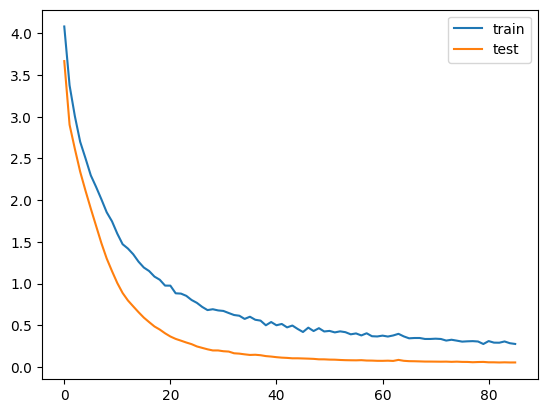

In [39]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [59]:
def getSpeaker(speaker):
    speaker = "Speaker"+str(speaker).zfill(3)
    return speaker
    
        
def printPrediction(X_data, y_data, printDigit, model):
    print('\n# Generate predictions')
    for i in range(len(y_data)):
        predict_x=model.predict(X_data[i:i+1])[0]
        predict_classes = np.argmax(predict_x)
        print(predict_classes)
        prediction = getSpeaker(predict_classes)
    
        speaker = getSpeaker(y_data[i])
        if printDigit == True:
           print("Number={0:d}, y={1:10s}- prediction={2:10s}- match={3}".format(i, speaker, prediction, speaker==prediction))
        else:
           print("y={0:10s}- prediction={1:10s}- match={2}".format(speaker, prediction, speaker==prediction))

In [37]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

def report(X_data, y_data):
    #Confution Matrix and Classification Report
    predict_y = model.predict(X_data)
    Y_pred = np.argmax(predict_y, axis=1)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt[6])
    key=0
    for val in conf_mt[6]:
        if val!=0:
            print(key)
        key=key+1
    conf_mt=conf_mt / conf_mt.astype(np.float).sum(axis=1)
    #print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, Y_pred))


In [41]:
print('\n# TEST DATA #\n')
y_test=np.array(y_test, dtype=int)
score = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
# Prediction
printPrediction(X_test[0:20], y_test[0:20], False, model)


# TEST DATA #

27/27 [==============================] - 0s 864us/step - loss: 0.7388 - accuracy: 0.9246
accuracy: 92.46%

# Generate predictions
1/1 [==============================] - 0s 43ms/step
43
y=Speaker032- prediction=Speaker043- match=False
1/1 [==============================] - 0s 14ms/step
54
y=Speaker054- prediction=Speaker054- match=True
1/1 [==============================] - 0s 15ms/step
13
y=Speaker013- prediction=Speaker013- match=True
1/1 [==============================] - 0s 15ms/step
48
y=Speaker048- prediction=Speaker048- match=True
1/1 [==============================] - 0s 15ms/step
1
y=Speaker001- prediction=Speaker001- match=True
1/1 [==============================] - 0s 16ms/step
19
y=Speaker019- prediction=Speaker019- match=True
1/1 [==============================] - 0s 15ms/step
0
y=Speaker000- prediction=Speaker000- match=True
1/1 [==============================] - 0s 15ms/step
53
y=Speaker052- prediction=Speaker053- match=False
1/1 [=========================

Classification Report for Test Data

27/27 [==============================] - 0s 747us/step
[ 0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0]
2


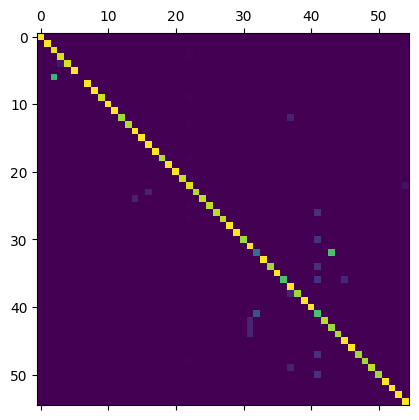


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        24
           2       0.59      0.96      0.73        24
           3       0.94      0.94      0.94        17
           4       1.00      0.94      0.97        18
           5       1.00      1.00      1.00        15
           6       0.00      0.00      0.00        16
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        20
           9       1.00      0.92      0.96        13
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        13
          12       1.00      0.86      0.92         7
          13       1.00      0.88      0.93         8
          14       0.92      1.00      0.96        11
          15       1.00      1.00      1.00         8
          16       0.91      1.00      0.95        10
    

In [43]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

### Save model

In [16]:
model.save('speaker-recognition.h5')


Transfer learning

https://keras.io/guides/transfer_learning/


### Load model

In [10]:
new_model = keras.models.load_model('speaker-recognition.h5')
#printPrediction(X_test[0:20], y_test[0:20], False, new_model)

In [11]:
#filename='Speaker0055_477.wav'
extractWavFeatures("audios/audios/one_test", final_test)

The features of the files in the folder audios/audios/one_test will be saved to final_test.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


100%|█████████████████████████████████████████| 301/301 [02:29<00:00,  2.02it/s]

End of extractWavFeatures


In [12]:
trainData = preProcessData(TRAIN_CSV_FILE)
final_testData = preProcessData(final_test)

train.csv will be preprocessed
Preprocessing is finished
       rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0  0.044474        2925.986137         2426.865665  5365.750887   
1  0.007040        1054.481600          969.009484  2158.703613   
2  0.059307         644.962153          689.094968  1064.355469   
3  0.033733        1679.723927         1658.148768  3240.135427   
4  0.034633        1303.101750         1210.428356  2418.177044   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0            0.170812 -292.403381   69.789474 -19.889078   4.436610   
1            0.055127 -541.293884  209.900482 -59.150311  35.763649   
2            0.034738 -379.739685  229.126648 -13.465721   7.315946   
3            0.116656 -384.844421  104.027542  -0.869874  44.156509   
4            0.083430 -420.164368  131.315445   6.856723  27.124081   

       mfcc5  ...     mfcc12     mfcc13    mfcc14     mfcc15     mfcc16  \
0  -3.878308  ...  -2.387268  -6.74580

In [13]:
# Splitting the dataset into training, validation and testing dataset
from sklearn.model_selection import train_test_split
X = np.array(trainData.iloc[:, :-1], dtype = float)
y = trainData.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)


X_test = np.array(final_testData.iloc[:, :-1], dtype = float)
y_test = final_testData.iloc[:, -1]

print("Y from training data:", y_train.shape)
print("Y from validation data:", y_val.shape)
print("Y from test data:", y_test.shape)

Y from training data: (2284,)
Y from validation data: (979,)
Y from test data: (301,)


In [14]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )
X_test = scaler.transform( X_test )

print("X from training data", X_train.shape)
print("X from validation data", X_val.shape)
print("X from test data", X_test.shape)


X from training data (2284, 25)
X from validation data (979, 25)
X from test data (301, 25)


In [15]:
print('\n# TEST DATA #\n')
y_test=np.array(y_test, dtype=int)
score = new_model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (new_model.metrics_names[1], score[1]*100))
# Prediction
printPrediction(X_test[0:20], y_test[0:20], False, new_model)


# TEST DATA #

10/10 [==============================] - 0s 4ms/step - loss: 0.2039 - accuracy: 0.9767
accuracy: 97.67%

# Generate predictions
1/1 [==============================] - 0s 206ms/step
y=Speaker054- prediction=Speaker054- match=True
1/1 [==============================] - 0s 43ms/step
y=Speaker052- prediction=Speaker053- match=False
1/1 [==============================] - 0s 54ms/step
y=Speaker054- prediction=Speaker054- match=True
1/1 [==============================] - 0s 52ms/step
y=Speaker055- prediction=Speaker055- match=True
1/1 [==============================] - 0s 49ms/step
y=Speaker009- prediction=Speaker009- match=True
1/1 [==============================] - 0s 48ms/step
y=Speaker007- prediction=Speaker007- match=True
1/1 [==============================] - 0s 52ms/step
y=Speaker037- prediction=Speaker037- match=True
1/1 [==============================] - 0s 48ms/step
y=Speaker005- prediction=Speaker005- match=True
1/1 [==============================] - 0s 47ms/step
y=